# LoRA implementation for finetuning a model trained on MNIST (just digits) for EMNIST (letters)
inspired by: https://github.com/hkproj/pytorch-lora, https://www.youtube.com/watch?v=PXWYUTMt-AU

paper referred to: https://arxiv.org/abs/2106.09685

In [1]:
import torch
import torchvision.datasets as datasets 
import torchvision.transforms as transforms
import torch.nn as nn

### Load MNIST and EMNIST data

In [2]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.1307,), (0.3081,))])

# MNIST datasets
mnist_full_train = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
train_size = int(0.8 * len(mnist_full_train))
val_size = len(mnist_full_train) - train_size
mnist_trainset, mnist_valset = torch.utils.data.random_split(mnist_full_train, [train_size, val_size])

mnist_train_loader = torch.utils.data.DataLoader(mnist_trainset, batch_size=64, shuffle=True)
mnist_val_loader = torch.utils.data.DataLoader(mnist_valset, batch_size=64, shuffle=False)
mnist_testset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
mnist_test_loader = torch.utils.data.DataLoader(mnist_testset, batch_size=64, shuffle=True)

# EMNIST datasets
emnist_full_train = datasets.EMNIST(root='./data', split='letters', train=True, download=True, transform=transform)
train_size = int(0.8 * len(emnist_full_train))
val_size = len(emnist_full_train) - train_size
emnist_trainset, emnist_valset = torch.utils.data.random_split(emnist_full_train, [train_size, val_size])

emnist_train_loader = torch.utils.data.DataLoader(emnist_trainset, batch_size=64, shuffle=True)
emnist_val_loader = torch.utils.data.DataLoader(emnist_valset, batch_size=64, shuffle=False)
emnist_testset = datasets.EMNIST(root='./data', split='letters', train=False, download=True, transform=transform)
emnist_test_loader = torch.utils.data.DataLoader(emnist_testset, batch_size=64, shuffle=True)

# Define the device
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

### Some information about and examples from the datasets

MNIST Dataset:
Training set size: 48000
Validation set size: 12000
Test set size: 10000

EMNIST Dataset:
Training set size: 99840
Validation set size: 24960
Test set size: 20800


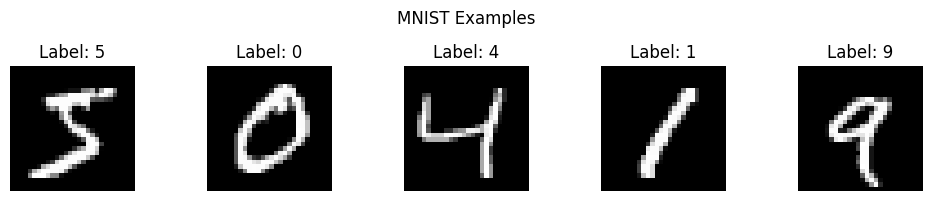

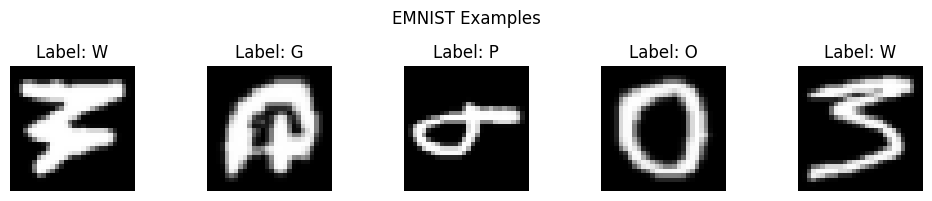


Number of classes:
MNIST: 10
EMNIST: 26


In [3]:
# Print dataset sizes
print("MNIST Dataset:")
print(f"Training set size: {len(mnist_trainset)}")
print(f"Validation set size: {len(mnist_valset)}")
print(f"Test set size: {len(mnist_testset)}")
print("\nEMNIST Dataset:")
print(f"Training set size: {len(emnist_trainset)}")
print(f"Validation set size: {len(emnist_valset)}")
print(f"Test set size: {len(emnist_testset)}")

# Visualize some examples
import matplotlib.pyplot as plt

# Function to show images
def show_examples(dataset, title, num_examples=5, mnist=True):
    fig, axes = plt.subplots(1, num_examples, figsize=(2*num_examples, 2))
    fig.suptitle(title)
    
    for i in range(num_examples):
        img, label = dataset[i]
        if not mnist:
            label = chr(ord('A') + label - 1)  # Convert number to corresponding letter
        axes[i].imshow(img.squeeze(), cmap='gray')
        axes[i].axis('off')
        axes[i].set_title(f'Label: {label}')
    plt.tight_layout()
    plt.show()

# Show examples from both datasets
show_examples(mnist_full_train, "MNIST Examples")
show_examples(emnist_full_train, "EMNIST Examples", mnist=False)

# Print number of classes
print("\nNumber of classes:")
print(f"MNIST: {len(set(mnist_full_train.targets.numpy()))}")
print(f"EMNIST: {len(set(emnist_full_train.targets.numpy()))}")


### Create simple Feedforward Neural Network

In [4]:
import torch.nn.functional as F
import pytorch_lightning as L

class SimpleNN(L.LightningModule):
    def __init__(self):
        super(SimpleNN, self).__init__()
        self.l1 = nn.Linear(28*28, 2000)
        self.l2 = nn.Linear(2000, 1500)
        self.l3 = nn.Linear(1500, 1000)
        self.l4 = nn.Linear(1000, 500)
        self.l5 = nn.Linear(500, 250)
        self.l6 = nn.Linear(250, 10)
        self.dropout = nn.Dropout(0.2)

    def forward(self, x):
        x = x.view(-1, 28*28)
        x = F.relu(self.l1(x))
        x = self.dropout(x)
        x = F.relu(self.l2(x))
        x = self.dropout(x)
        x = F.relu(self.l3(x))
        x = self.dropout(x)
        x = F.relu(self.l4(x))
        x = self.dropout(x)
        x = F.relu(self.l5(x))
        x = self.dropout(x)
        x = self.l6(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        acc = (logits.argmax(dim=1) == y).float().mean()
        self.log('val_loss', loss)
        self.log('val_acc', acc)
        return loss

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=0.001)

base_model = SimpleNN()
base_model

SimpleNN(
  (l1): Linear(in_features=784, out_features=2000, bias=True)
  (l2): Linear(in_features=2000, out_features=1500, bias=True)
  (l3): Linear(in_features=1500, out_features=1000, bias=True)
  (l4): Linear(in_features=1000, out_features=500, bias=True)
  (l5): Linear(in_features=500, out_features=250, bias=True)
  (l6): Linear(in_features=250, out_features=10, bias=True)
  (dropout): Dropout(p=0.2, inplace=False)
)

### Train the model

In [5]:
trainer = L.Trainer(max_epochs=3)
trainer.fit(base_model, mnist_train_loader, mnist_val_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/Users/i551965/Documents/dev/SAP/DeepLearning/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/logger_connector/logger_connector.py:75: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `pytorch_lightning` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | l1      | Linear  | 1.6 M  | train
1 | l2      | Linear  | 3.0 M  | train
2 | l3      | Linear  | 1.5 M  | train
3 | l4      | Linear  | 500 K  | train
4 | l5      | Linear  | 125 K  | train
5 | l6      | Linear  | 2.5 K  | train
6

Sanity Checking DataLoader 0:   0%|          | 0/2 [00:00<?, ?it/s]

/Users/i551965/Documents/dev/SAP/DeepLearning/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


/Users/i551965/Documents/dev/SAP/DeepLearning/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:424: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=9` in the `DataLoader` to improve performance.


Epoch 2: 100%|██████████| 750/750 [00:08<00:00, 90.10it/s, v_num=66] 

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 750/750 [00:08<00:00, 89.37it/s, v_num=66]


### Evaluate the model

In [6]:
print("MNIST")
trainer.validate(model=base_model, dataloaders=mnist_test_loader)
print("EMNIST")
trainer.validate(model=base_model, dataloaders=emnist_test_loader)

MNIST


/Users/i551965/Documents/dev/SAP/DeepLearning/.venv/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:475: Your `val_dataloader`'s sampler has shuffling enabled, it is strongly recommended that you turn shuffling off for val/test dataloaders.


Validation DataLoader 0: 100%|██████████| 157/157 [00:01<00:00, 156.98it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc             0.97079998254776
        val_loss            0.10735946148633957
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
EMNIST
Validation DataLoader 0: 100%|██████████| 325/325 [00:01<00:00, 202.30it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc           0.014759615063667297
      

[{'val_loss': 3.2453672885894775, 'val_acc': 0.014759615063667297}]

### Create LoRA model

In [7]:
class LoRAParametrization(L.LightningModule):
    def __init__(self, features_in, features_out, rank=1, alpha=1, device=device):
        super().__init__()
        # Section 4.1 of the paper: 
        #   We use a random Gaussian initialization for A and zero for B, so ∆W = BA is zero at the beginning of training
        self.lora_A = nn.Parameter(torch.zeros((rank,features_out)).to(device))
        self.lora_B = nn.Parameter(torch.zeros((features_in, rank)).to(device))
        nn.init.normal_(self.lora_A, mean=0, std=1)
        
        # Section 4.1 of the paper: 
        #   We then scale ∆Wx by α/r , where α is a constant in r. 
        #   When optimizing with Adam, tuning α is roughly the same as tuning the learning rate if we scale the initialization appropriately. 
        #   As a result, we simply set α to the first r we try and do not tune it. 
        #   This scaling helps to reduce the need to retune hyperparameters when we vary r.
        self.scale = alpha / rank

    def forward(self, original_weights):
        # Return W + (B*A)*scale
        return original_weights + (self.lora_B @ self.lora_A) * self.scale

### Add parametrization to the model

In [8]:
import torch.nn.utils.parametrize as parametrize
import copy

def linear_layer_parameterization(layer, device, rank=1, lora_alpha=1):
    # Only add the parameterization to the weight matrix, ignore the Bias

    # From section 4.2 of the paper:
    #   We limit our study to only adapting the attention weights for downstream tasks 
    #   and freeze the MLP modules (so they are not trained in downstream tasks) both 
    #   for simplicity and parameter-efficiency.
    #   [...]
    #   We leave the empirical investigation of [...], and biases to a future work.
    
    features_in, features_out = layer.weight.shape
    return LoRAParametrization(
        features_in, features_out, rank=rank, alpha=lora_alpha, device=device
    )

# Creating a copy of the base model to finetune without LoRA
lora_finetune_model = copy.deepcopy(base_model)

parametrize.register_parametrization(
    lora_finetune_model.l1, "weight", linear_layer_parameterization(lora_finetune_model.l1, device)
)
parametrize.register_parametrization(
    lora_finetune_model.l2, "weight", linear_layer_parameterization(lora_finetune_model.l2, device)
)
parametrize.register_parametrization(
    lora_finetune_model.l3, "weight", linear_layer_parameterization(lora_finetune_model.l3, device)
)
parametrize.register_parametrization(
    lora_finetune_model.l4, "weight", linear_layer_parameterization(lora_finetune_model.l4, device)
)
parametrize.register_parametrization(
    lora_finetune_model.l5, "weight", linear_layer_parameterization(lora_finetune_model.l5, device)
)
parametrize.register_parametrization(
    lora_finetune_model.l6, "weight", linear_layer_parameterization(lora_finetune_model.l6, device)
)

lora_finetune_model

SimpleNN(
  (l1): ParametrizedLinear(
    in_features=784, out_features=2000, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRAParametrization()
      )
    )
  )
  (l2): ParametrizedLinear(
    in_features=2000, out_features=1500, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRAParametrization()
      )
    )
  )
  (l3): ParametrizedLinear(
    in_features=1500, out_features=1000, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRAParametrization()
      )
    )
  )
  (l4): ParametrizedLinear(
    in_features=1000, out_features=500, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRAParametrization()
      )
    )
  )
  (l5): ParametrizedLinear(
    in_features=500, out_features=250, bias=True
    (parametrizations): ModuleDict(
      (weight): ParametrizationList(
        (0): LoRAParam

### Freeze all non-LoRA parameters

In [9]:
# Freeze the non-Lora parameters
for name, param in lora_finetune_model.named_parameters():
    if 'lora' not in name:
        print(f'Freezing non-LoRA parameter {name}')
        param.requires_grad = False

Freezing non-LoRA parameter l1.bias
Freezing non-LoRA parameter l1.parametrizations.weight.original
Freezing non-LoRA parameter l2.bias
Freezing non-LoRA parameter l2.parametrizations.weight.original
Freezing non-LoRA parameter l3.bias
Freezing non-LoRA parameter l3.parametrizations.weight.original
Freezing non-LoRA parameter l4.bias
Freezing non-LoRA parameter l4.parametrizations.weight.original
Freezing non-LoRA parameter l5.bias
Freezing non-LoRA parameter l5.parametrizations.weight.original
Freezing non-LoRA parameter l6.bias
Freezing non-LoRA parameter l6.parametrizations.weight.original


### Verify that parameters are actually frozen

In [10]:
trainable_params = sum(p.numel() for p in lora_finetune_model.parameters() if p.requires_grad)
total_params = sum(p.numel() for p in lora_finetune_model.parameters())
print(f"Trainable parameters: {trainable_params}")
print(f"Total parameters: {total_params}")
print(f"Percentage of trainable parameters: {trainable_params/total_params*100:.2f}%")

Trainable parameters: 11294
Total parameters: 6712054
Percentage of trainable parameters: 0.17%


### Fine-tune the model on EMNIST using LoRA

In [11]:
import pendulum

trainer = L.Trainer(max_epochs=3)
# Measure training time
start_time = pendulum.now()
trainer.fit(lora_finetune_model, emnist_train_loader, emnist_val_loader)
training_time_lora = pendulum.now().diff(start_time).in_seconds()
print(f"Training time with LoRA: {training_time_lora:.2f} seconds")

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type               | Params | Mode 
-------------------------------------------------------
0 | l1      | ParametrizedLinear | 1.6 M  | train
1 | l2      | ParametrizedLinear | 3.0 M  | train
2 | l3      | ParametrizedLinear | 1.5 M  | train
3 | l4      | ParametrizedLinear | 502 K  | train
4 | l5      | ParametrizedLinear | 126 K  | train
5 | l6      | ParametrizedLinear | 2.8 K  | train
6 | dropout | Dropout            | 0      | train
-------------------------------------------------------
11.3 K    Trainable params
6.7 M     Non-trainable params
6.7 M     Total params
26.848    Total estimated model params size (MB)
25        Modules in train mode
0         Modules in eval mode


Epoch 2: 100%|██████████| 1560/1560 [00:17<00:00, 87.03it/s, v_num=67]     

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1560/1560 [00:17<00:00, 86.86it/s, v_num=67]
Training time with LoRA: 55.00 seconds


### Evaluate the fine-tuned model

In [12]:
print("MNIST")
accuracy_lora_mnist = trainer.validate(model=lora_finetune_model, dataloaders=mnist_test_loader)
print("EMNIST")
accuracy_lora_emnist = trainer.validate(model=lora_finetune_model, dataloaders=emnist_test_loader)

MNIST
Validation DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 173.84it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.13099999725818634
        val_loss            3.4808096885681152
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
EMNIST
Validation DataLoader 0: 100%|██████████| 325/325 [00:01<00:00, 187.75it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.25370192527770996

### Finetune without LoRA to compare accuracy and runtime

In [13]:
# Finetune the base model without LoRA
no_lora_finetune_model = copy.deepcopy(base_model)

trainer = L.Trainer(max_epochs=3)

start_time = pendulum.now()
trainer.fit(no_lora_finetune_model, emnist_train_loader, emnist_val_loader)
training_time_no_lora = pendulum.now().diff(start_time).in_seconds()
print(f"Training time without LoRA: {training_time_no_lora:.2f} seconds")

### Evaluate the finetuned model without LoRA
print("MNIST")
accuracy_no_lora_mnist = trainer.validate(model=no_lora_finetune_model, dataloaders=mnist_test_loader)
print("EMNIST")
accuracy_no_lora_emnist = trainer.validate(model=no_lora_finetune_model, dataloaders=emnist_test_loader)

GPU available: True (mps), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs

  | Name    | Type    | Params | Mode 
--------------------------------------------
0 | l1      | Linear  | 1.6 M  | train
1 | l2      | Linear  | 3.0 M  | train
2 | l3      | Linear  | 1.5 M  | train
3 | l4      | Linear  | 500 K  | train
4 | l5      | Linear  | 125 K  | train
5 | l6      | Linear  | 2.5 K  | train
6 | dropout | Dropout | 0      | train
--------------------------------------------
6.7 M     Trainable params
0         Non-trainable params
6.7 M     Total params
26.803    Total estimated model params size (MB)
7         Modules in train mode
0         Modules in eval mode


Epoch 2: 100%|██████████| 1560/1560 [00:18<00:00, 84.54it/s, v_num=68]      

`Trainer.fit` stopped: `max_epochs=3` reached.


Epoch 2: 100%|██████████| 1560/1560 [00:18<00:00, 84.22it/s, v_num=68]
Training time without LoRA: 53.00 seconds
MNIST
Validation DataLoader 0: 100%|██████████| 157/157 [00:00<00:00, 207.33it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
         val_acc            0.0828000009059906
        val_loss             6.055171966552734
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
EMNIST
Validation DataLoader 0: 100%|██████████| 325/325 [00:01<00:00, 200.87it/s]
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────

### Compare Finetuning with and without LoRA

In [14]:
# Training time
print(f"Training time with LoRA: {training_time_lora:.2f} seconds")
print(f"Training time without LoRA: {training_time_no_lora:.2f} seconds")
print()

# Accuracy on both datasets
print(f"Accuracy with LoRA on MNIST: {accuracy_lora_mnist[0]['val_acc']:.2f}")
print(f"Accuracy with LoRA on EMNIST: {accuracy_lora_emnist[0]['val_acc']:.2f}")
print(f"Accuracy without LoRA on MNIST: {accuracy_no_lora_mnist[0]['val_acc']:.2f}")
print(f"Accuracy without LoRA on EMNIST: {accuracy_no_lora_emnist[0]['val_acc']:.2f}")

Training time with LoRA: 55.00 seconds
Training time without LoRA: 53.00 seconds

Accuracy with LoRA on MNIST: 0.13
Accuracy with LoRA on EMNIST: 0.25
Accuracy without LoRA on MNIST: 0.08
Accuracy without LoRA on EMNIST: 0.32
